# Simulation of a Multi-Server Queueing System with Jockeying (Banking Queue System)

This notebook simulates a banking queue system with **multiple tellers and jockeying** using the `simpy` library.

The simulation models customer arrivals, service times, queue dynamics, and **jockeying behavior** to analyze various performance metrics of the system.

## System Description

- **Multiple Tellers**: The bank has multiple tellers (servers), each with their own separate queue.
- **Customer Arrival**: Arriving customers join the **shortest queue**, choosing the **leftmost** shortest queue in case of ties.
- **Jockeying**: When a customer's service completes at teller $i$, if any other teller $j$ has $n_j > n_i + 1$ customers (where $n_i$ is the total number at teller $i$ including any in service), then the customer at the **tail** of queue $j$ moves to the **tail** of queue $i$.

## Assumptions

- **Interarrival times**: Exponentially distributed with mean **1 minute** ($\lambda = 1$ customer/minute)
- **Service times**: Exponentially distributed with mean **4.5 minutes** ($\mu = 1/4.5$ customers/minute)

## Objectives

We aim to measure and analyze the following performance metrics for systems with **4, 5, 6, and 7 tellers**:

1. **Average inter-arrival time $E[1/\lambda]$**: The average time between customer arrivals.
2. **Average service time $E[S]$**: The average time taken to serve a customer.
3. **Average delay time $E[D]$**: The average time customers spend waiting in the queue.
4. **Average number of customers in the system $E[N]$**: The average total number of customers.
5. **Server utilization rate $E[U]$**: The proportion of time the servers are busy.
6. **Jockeying statistics**: Number of jockeying events and their impact on performance.


In [1]:
from __future__ import annotations

import random
import statistics
from collections import defaultdict
from collections.abc import Generator, Iterable
from typing import Any, NoReturn, Optional

import matplotlib.pyplot as plt
import simpy
from simpy import Process
from simpy.events import Timeout
from simpy.resources.resource import Release, Request

In [2]:
class Customer:
    def __init__(
        self,
        env: simpy.Environment,
        bank: Bank,
        arrival_time: float,
        service_time: float,
    ) -> None:
        self.env = env
        self.bank = bank
        self.arrival_time: float = arrival_time
        self.service_time: float = service_time

        self.delay: Optional[float] = None

        self.jovkeyed: bool = False
        self.current_teller: Optional[Teller] = None
        self.request: Optional[Request] = None
        self.served: bool = False

    def main(self) -> Generator[Request | Process, None]:
        self.current_teller = self.bank.get_shortest_queue()

        while not self.served:

            teller = self.current_teller
            teller.waiting_customers.append(self)

            queue_entry_time = self.env.now

            self.request = teller.request()
            yield self.request  # Wait for teller

            if not self.jovkeyed:  # Wasn't moved while waiting
                teller.waiting_customers.remove(self)

                self.delay = self.env.now - queue_entry_time

                yield self.env.process(teller.process_customer(self))

                teller.release(self.request)
                self.bank.check_jockeying(freed_teller=teller)
                self.served = True
            else:
                self.jovkeyed = False

    def cancel_request(self) -> None:
        if self.request is not None:
            self.request.cancel()


class Teller(simpy.Resource):
    def __init__(self, env: simpy.Environment, capacity: int) -> None:
        super().__init__(env, capacity)
        self.env = env
        self.queue_history: dict[int, float] = defaultdict(float)
        # queue time points
        self.qt: list[tuple[float, int]] = []
        # utilization rate time points
        self.ut: list[tuple[float, int]] = [(0, 0)]

        self.last_queue_level: int = 0
        self.last_queue_level_timestamp: float = 0

        self.worked_time: float = 0

        self.waiting_customers: list[Customer] = []

    @property
    def average_queue_length(self) -> float:
        return (
            sum(
                queue_length * time for queue_length, time in self.queue_history.items()
            )
            / self.env.now
        )

    @property
    def utilization_rate(self) -> float:
        return self.worked_time / self.env.now

    def _update_qt(self) -> None:
        self.qt.append((self.env.now, len(self.queue)))

    def _update_ut(self) -> None:
        status = int(self.count == 1 or len(self.queue) > 0)
        if self.ut and self.ut[-1][1] == status:
            return
        self.ut.append((self.env.now, status))

    def _update_queue_history(self, _) -> None:
        self.queue_history[self.last_queue_level] += (
            self.env.now - self.last_queue_level_timestamp
        )
        self.last_queue_level_timestamp = self.env.now
        self.last_queue_level = len(self.queue)
        self._update_qt()

    def request(self) -> Request:
        request = super().request()
        self._update_queue_history(None)

        request.callbacks.append(self._update_queue_history)
        return request

    def release(self, request: Request) -> Release:
        release = super().release(request)
        self._update_ut()
        return release

    def process_customer(self, customer: Customer) -> Generator[Timeout, None, None]:
        yield self.env.timeout(customer.service_time)
        self.worked_time += customer.service_time

    def plot_qt(self) -> None:
        x, y = zip(*self.qt)
        plt.step(x, y, where="pre")
        plt.fill_between(x, y, step="pre", alpha=1.0)
        plt.title("Q(t): Queue length over time")
        plt.xlabel("Simulation Time")
        plt.ylabel("Queue Length")
        plt.show()

    def plot_ut(self) -> None:
        ut = self.ut + [(self.env.now, self.ut[-1][1])]
        x, y = zip(*ut)
        plt.step(x, y, where="post")
        plt.fill_between(x, y, step="post", alpha=1.0)
        plt.title("U(t): Teller utilization over time")
        plt.xlabel("Simulation Time")
        plt.ylabel("Utilization rate")
        plt.show()


class Bank:
    def __init__(
        self,
        env: simpy.Environment,
        num_tellers: int,
        customer_arrival_rate: float,
        customer_average_processing_time: float,
    ) -> None:
        self.env = env

        # M/M/c queueing system
        self.tellers = [Teller(env, capacity=1) for _ in range(num_tellers)]

        # Rate of customer arrivals
        # λ = 1 / mean, where λ is the rate parameter [customers/minute]
        self.customer_arrival_rate = customer_arrival_rate

        # Average processing time for a customer
        # [minutes/customer]
        self.customer_average_processing_time = customer_average_processing_time

        self.customers_inter_arrival_times: list[float] = []
        self.customers: list[Customer] = []

    @property
    def customer_service_times(self) -> Iterable[float]:
        for customer in self.customers:
            yield customer.service_time

    @property
    def customer_delay_times(self) -> Iterable[float]:
        for customer in self.customers:
            if customer.delay is not None:
                yield customer.delay

    def get_shortest_queue(self) -> Teller:

        # return the teller with the shortest queue, or the leftmost one in case of a tie
        return min(self.tellers, key=lambda teller: len(teller.queue) + teller.count)

    def check_jockeying(self, freed_teller: Teller) -> None:
        n_i = len(freed_teller.queue) + freed_teller.count

        for other_teller in self.tellers:
            if other_teller is freed_teller:
                continue
            n_j = len(other_teller.queue) + other_teller.count
            if n_j >= n_i + 1 and other_teller.waiting_customers:
                customer_to_jockey = other_teller.waiting_customers.pop(0)

                customer_to_jockey.jovkeyed = True
                customer_to_jockey.current_teller = freed_teller

                customer_to_jockey.cancel_request()

                other_teller._update_queue_history(None)
                freed_teller._update_queue_history(None)

                break

    def run(self) -> Generator[Timeout, Any, NoReturn]:
        while True:
            # Exponential distribution
            # λ = 1 / mean, where λ is the rate parameter [customers/minute]
            # mean := average delta time from one customer to the next (in minutes)
            customer_inter_arrival_time = random.expovariate(
                lambd=self.customer_arrival_rate
            )
            self.customers_inter_arrival_times.append(customer_inter_arrival_time)

            # Exponential distribution
            # λ = 1 / mean, where λ is the rate parameter [customers/minute]
            # mean := average processing time for a customer (in minutes)
            customer_service_time = random.expovariate(
                1 / self.customer_average_processing_time
            )

            # Wait for the next customer to arrive
            yield self.env.timeout(customer_inter_arrival_time)

            # Generate a new customer
            customer = Customer(
                env=self.env,
                bank=self,
                arrival_time=self.env.now,
                service_time=customer_service_time,
            )
            self.customers.append(customer)

            self.env.process(customer.main())

In [3]:
seed = 42
random.seed(seed)

env = simpy.Environment()
bank = Bank(
    env,
    num_tellers=4,
    # 1 customer/minute arrival rate
    customer_arrival_rate=1,
    # Mean service time = 4.5 minutes
    customer_average_processing_time=4.5,
)
env.process(bank.run())
env.run(until=60 * 24 * 10)  # 10 days in minutes

## Average inter-arrival time E[1/λ]


Average Customer Inter-arrival time = 1.00 minutes


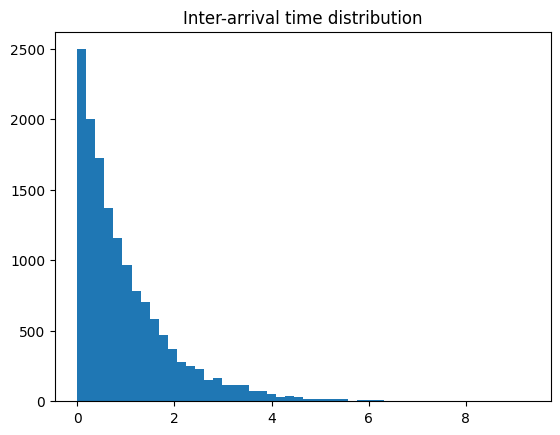

In [4]:
average_customer_inter_arrival_time = statistics.mean(
    bank.customers_inter_arrival_times
)
print(
    f"Average Customer Inter-arrival time = {average_customer_inter_arrival_time:.2f} minutes"
)
plt.hist(bank.customers_inter_arrival_times, bins=50)
plt.title("Inter-arrival time distribution")
plt.show()

## Average service time E[S]


Average Customer service time = 4.49 minutes


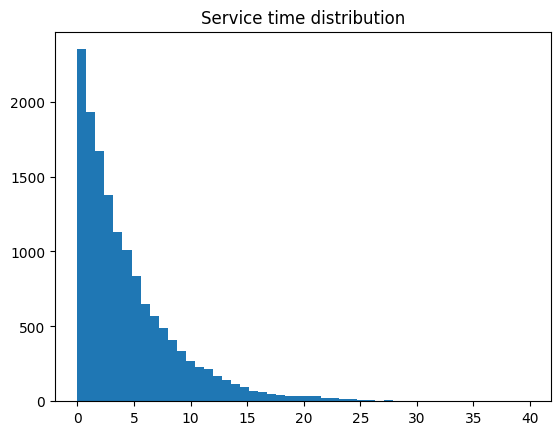

In [5]:
average_customer_service_time = statistics.mean(bank.customer_service_times)
print(f"Average Customer service time = {average_customer_service_time:.2f} minutes")
plt.hist(list(bank.customer_service_times), bins=50)
plt.title("Service time distribution")
plt.show()

## Average delay time E[D]


In [ ]:
average_customer_delay_time = statistics.mean(bank.customer_delay_times)
print(f"Average Customer delay time = {average_customer_delay_time:.2f} minutes")
plt.hist(list(bank.customer_delay_times), bins=10)
plt.title("Customers delay distribution")
plt.show()

## Average number of customers in the queue E[Q]


In [ ]:
average_cashier_queue_length = bank.cashier.average_queue_length
print(f"Average Cashier queue length = {average_cashier_queue_length:.2f}")
bank.cashier.plot_qt()

## Server utilization rate E[U]


In [ ]:
average_utilization_rate = bank.cashier.utilization_rate
print(f"Average Server Utilization rate = {average_utilization_rate * 100:.2f}%")
bank.cashier.plot_ut()

In [ ]:
random.seed(None)

from tqdm import tqdm

results = []
for _ in tqdm(range(50)):
    random.seed(_)
    env = simpy.Environment()
    bank = Bank(
        env,
        num_tellers=4,
        customer_arrival_rate=4,
        customer_average_processing_time=1 / 5,
    )
    env.process(bank.run())
    env.run(until=60 * 24 * 50)  # minutes
    results.append(bank.cashier.average_queue_length)

In [ ]:
m = statistics.mean(results)
s = statistics.stdev(results)

# margin of error
# 95% confidence interval
# z = 1.96 for 95% confidence
# z = 2.576 for 99% confidence
moe = 1.96 * s / len(results) ** 0.5

print(f"Average Cashier queue length = {m:.2f} ± {moe:.2f}")

In [ ]:
ro = 0.8  # true utilization rate (aka traffic intensity)
true_average_queue_length = ro**2 / (1 - ro)
print(f"Average Queue Length = {true_average_queue_length:.2f}")
m - moe <= true_average_queue_length <= m + moe